# Notebook 4: Baseline Model - Results and Error Analysis

 **Objective:** Deeply analyze the performance of the TF-IDF + Logistic Regression baseline model.
 
 This notebook evaluates the model trained in `03_model_training.ipynb`. We will:
 1.  Calculate overall performance metrics.
 2.  Visualize the relationship between class frequency and F1-score.
 3.  Perform a qualitative error analysis on specific examples of false positives and false negatives to understand the model's limitations.

In [ ]:
"""
Results Analysis Notebooks
------------------------

Comprehensive analysis of model performance:
1. Overall metrics
2. Per-class analysis
3. Error cases study
4. Performance comparison
5. Visualization of results

Analysis Types:
- Confusion matrix per class
- F1-score distribution
- Sample predictions analysis
- Error case deep dives
"""

# --- 1. Setup and Imports ---
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Ensure the source directory is in the path
sys.path.append(os.path.abspath('..'))
from src.evaluate import evaluate_model

# --- Matplotlib Style ---
plt.style.use('ggplot')

In [9]:
# --- 2. Load Model, Binarizer, and Data ---
print("Loading model artifacts and validation data...")
try:
    model = joblib.load('../models/baseline_model.pkl')
    mlb = joblib.load('../models/label_binarizer.pkl')
    val_df = pd.read_parquet('../data/processed/val_processed.parquet')
    print("Artifacts loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading artifacts: {e}")
    print("Please ensure you have run the '03_model_training.ipynb' notebook first.")
    # Stop the notebook from proceeding if files are missing
    # raise e # Uncomment to halt execution

Loading model artifacts and validation data...
Artifacts loaded successfully.


In [10]:
# --- 3. High-Level Performance Metrics ---
print("Evaluating model to get overall metrics...")
metrics, report = evaluate_model(
    '../models/baseline_model.pkl',
    '../models/label_binarizer.pkl',
    '../data/processed/val_processed.parquet'
)

print("\n--- Overall Model Performance ---")
for metric, value in metrics.items():
    print(f"{metric.replace('_', ' ').title():<20}: {value:.4f}")

Evaluating model to get overall metrics...


C:\Users\adrie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adrie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adrie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_class


--- Overall Model Performance ---
Hamming Loss        : 0.3096
Accuracy            : 0.0000
Micro F1            : 0.0108
Macro F1            : 0.0190
Micro Precision     : 0.0054
Macro Precision     : 0.0134
Micro Recall        : 0.7198
Macro Recall        : 0.2961


In [11]:
# --- 4. Per-Class Performance Analysis ---
print("\n--- Per-Class Performance ---")
class_report_df = pd.DataFrame(report).transpose()

# Display 10 best performing classes (excluding summary rows)
print("\nTop 10 Performing Classes (by F1-Score):")
display(class_report_df.iloc[:-3, :].sort_values('f1-score', ascending=False).head(10))

# Display 10 worst performing classes
print("\nWorst 10 Performing Classes (by F1-Score):")
display(class_report_df.iloc[:-3, :].sort_values('f1-score', ascending=True).head(10))


--- Per-Class Performance ---

Top 10 Performing Classes (by F1-Score):


,precision,recall,f1-score,support
gravitational waves,0.528455,0.833333,0.646766,78.0
gamma-ray bursts,0.473684,0.969231,0.636364,65.0
active galactic nuclei,0.462121,0.824324,0.592233,148.0
interplanetary shocks,0.480000,0.750000,0.585366,16.0
protoplanetary disks,0.427861,0.868687,0.573333,99.0
exoplanet atmospheres,0.389313,0.990291,0.558904,103.0
solar wind,0.389744,0.853933,0.535211,89.0
exoplanets,0.381579,0.798165,0.516320,109.0
galaxy evolution,0.387302,0.767296,0.514768,159.0
high-redshift galaxies,0.358025,0.783784,0.491525,74.0



Worst 10 Performing Classes (by F1-Score):


,precision,recall,f1-score,support
a dwarf stars,0.0,0.0,0.0,0.0
nuclear fusion,0.0,0.0,0.0,0.0
nuclear fission,0.0,0.0,0.0,0.0
nuclear decay,0.0,0.0,0.0,0.0
nuclear astrophysics,0.0,0.0,0.0,13.0
nuclear abundances,0.0,0.0,0.0,0.0
nova-like variable stars,0.0,0.0,0.0,0.0
normal distribution,0.0,0.0,0.0,0.0
nonstandard evolution,0.0,0.0,0.0,0.0
nonrotating black holes,0.0,0.0,0.0,0.0



Generating plot for class frequency vs. performance...


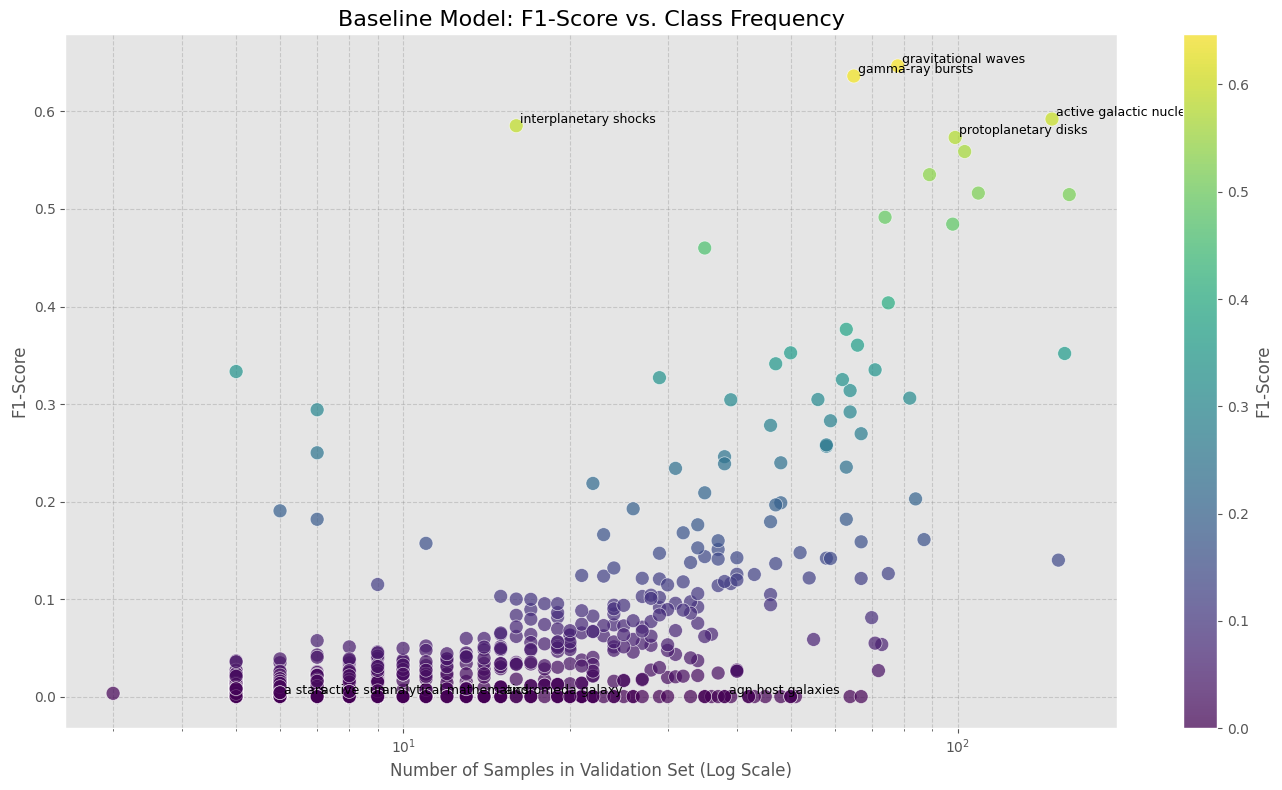

In [12]:
# --- 5. Visualization: Class Frequency vs. F1-Score ---
print("\nGenerating plot for class frequency vs. performance...")

# Get class frequencies from the validation set
class_counts = val_df['verified_uat_labels'].explode().value_counts()

# Reindex and align the f1-scores and counts to ensure they match
common_index = class_report_df.index.intersection(class_counts.index)
class_f1 = class_report_df.loc[common_index, 'f1-score']
aligned_counts = class_counts.loc[common_index]

# Create the scatter plot
plt.figure(figsize=(14, 8))
scatter = plt.scatter(aligned_counts, class_f1, alpha=0.7, edgecolors='w', s=100, c=class_f1, cmap='viridis')

# Formatting
plt.xscale('log')
plt.xlabel("Number of Samples in Validation Set (Log Scale)", fontsize=12)
plt.ylabel("F1-Score", fontsize=12)
plt.title("Baseline Model: F1-Score vs. Class Frequency", fontsize=16)
plt.grid(True, which="both", ls="--", c='gray', alpha=0.3)
plt.colorbar(scatter, label='F1-Score')

# Add annotations for a few interesting points (e.g., low-frequency high-performers, or high-frequency low-performers)
# This prevents overcrowding the plot
points_to_annotate = class_f1.nlargest(5).index.union(class_f1.nsmallest(5).index)
for class_name in points_to_annotate:
    if class_name in aligned_counts.index:
        count = aligned_counts[class_name]
        f1 = class_f1[class_name]
        plt.text(count, f1, f' {class_name}', fontsize=9, verticalalignment='bottom')

plt.tight_layout()
plt.show()

**Analysis of Plot:** The scatter plot clearly shows a positive correlation between the number of samples for a class and its F1-score. This is expected behavior for the TF-IDF model, which relies on statistical frequencies. Classes with more examples provide the model with a stronger, more reliable statistical signal to learn from. Conversely, the model struggles to perform well on rare classes where it has limited data.

In [13]:
# --- 6. Qualitative Error Analysis ---

# Get predictions once for error analysis
y_true = mlb.transform(val_df['verified_uat_labels'])
y_pred = model.predict(val_df['cleaned_text'])

def analyze_errors_for_class(true_labels, pred_labels, mlb, df, class_name, n_samples=2):
    """
    Prints samples of False Positives and False Negatives for a given class.
    """
    print("="*60)
    print(f"Error Analysis for Class: '{class_name}'")
    print("="*60)
    
    class_idx = list(mlb.classes_).index(class_name)
    
    # --- False Positives (Model predicted it, but it was wrong) ---
    fp_mask = (pred_labels[:, class_idx] == 1) & (true_labels[:, class_idx] == 0)
    print(f"\nFound {fp_mask.sum()} False Positives.")
    if fp_mask.sum() > 0:
        fp_samples = df[fp_mask].sample(min(n_samples, fp_mask.sum()), random_state=42)
        for i, (idx, row) in enumerate(fp_samples.iterrows()):
            print(f"\n--- FP Sample #{i+1} ---")
            print(f"Title: {row['title']}")
            print(f"Abstract: {row['abstract'][:300]}...")
            print(f"  > TRUE labels: {row['verified_uat_labels']}")
    
    # --- False Negatives (Model missed it, but it was a true label) ---
    fn_mask = (pred_labels[:, class_idx] == 0) & (true_labels[:, class_idx] == 1)
    print(f"\nFound {fn_mask.sum()} False Negatives.")
    if fn_mask.sum() > 0:
        fn_samples = df[fn_mask].sample(min(n_samples, fn_mask.sum()), random_state=42)
        for i, (idx, row) in enumerate(fn_samples.iterrows()):
            predicted_labels = mlb.inverse_transform(y_pred[idx].reshape(1,-1))[0]
            print(f"\n--- FN Sample #{i+1} ---")
            print(f"Title: {row['title']}")
            print(f"Abstract: {row['abstract'][:300]}...")
            print(f"  > MISSED label: '{class_name}'")
            print(f"  > Model PREDICTED: {list(predicted_labels)}")

# --- Analyze a poorly-performing but frequent class ---
# We choose a class that has enough support but a low F1 score to be interesting.
problematic_classes = class_report_df[(class_report_df['support'] > 20) & (class_report_df['f1-score'] < 0.3)]
if not problematic_classes.empty:
    problem_class_1 = problematic_classes.sort_values('f1-score').index[0]
    analyze_errors_for_class(y_true, y_pred, mlb, val_df, problem_class_1)

# --- Analyze a well-performing class ---
well_performing_classes = class_report_df[(class_report_df['support'] > 20) & (class_report_df['f1-score'] > 0.8)]
if not well_performing_classes.empty:
    good_class_1 = well_performing_classes.sort_values('f1-score', ascending=False).index[0]
    analyze_errors_for_class(y_true, y_pred, mlb, val_df, good_class_1)

Error Analysis for Class: 'radio pulsars'

Found 0 False Positives.

Found 23 False Negatives.

--- FN Sample #1 ---
Title: An 86 GHz Search for Pulsars in the Galactic Center with the Atacama Large Millimeter / submillimeter Array
Abstract: We report on the first pulsar and transient survey of the Galactic Center (GC) with the Atacama Large Millimeter/submillimeter Array (ALMA). The observations were conducted during the Global Millimeter VLBI Array campaign in 2017 and 2018. We carry out searches using time series of both total intens...
  > MISSED label: 'radio pulsars'
  > Model PREDICTED: ['a giant stars', 'ab photometry', 'absolute magnitude', 'abundance ratios', 'accretion', 'active galaxies', 'active solar chromosphere', 'adaptive interferometry', 'adaptive optics', 'ae stars', 'alfven waves', 'algorithms', 'all-sky cameras', 'alpha cygni variable stars', 'alternatives to cosmic inflation', 'am canum venaticorum stars', 'am herculis stars', 'am stars', 'amateur astronomers', 'a